In [2]:
pip install traci

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.9/149.9 kB 10.7 MB/s eta 0:00:00


In [3]:
!apt-get update
!apt-get install sumo sumo-tools sumo-doc

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,517 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,633 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd

 Retrying in 1 seconds
Episode 1/200 completed. Total reward: 1972
 Retrying in 1 seconds
Episode 2/200 completed. Total reward: 2175
 Retrying in 1 seconds
Episode 3/200 completed. Total reward: 2131
 Retrying in 1 seconds
Episode 4/200 completed. Total reward: 2115
 Retrying in 1 seconds
Episode 5/200 completed. Total reward: 2033
 Retrying in 1 seconds
Episode 6/200 completed. Total reward: 2043
 Retrying in 1 seconds
Episode 7/200 completed. Total reward: 2053
 Retrying in 1 seconds
Episode 8/200 completed. Total reward: 2017
 Retrying in 1 seconds
Episode 9/200 completed. Total reward: 2037
 Retrying in 1 seconds
Episode 10/200 completed. Total reward: 2081
 Retrying in 1 seconds
Episode 11/200 completed. Total reward: 2158
 Retrying in 1 seconds
Episode 12/200 completed. Total reward: 2119
 Retrying in 1 seconds
Episode 13/200 completed. Total reward: 2175
 Retrying in 1 seconds
Episode 14/200 completed. Total reward: 2091
 Retrying in 1 seconds
Episode 15/200 completed. Total re

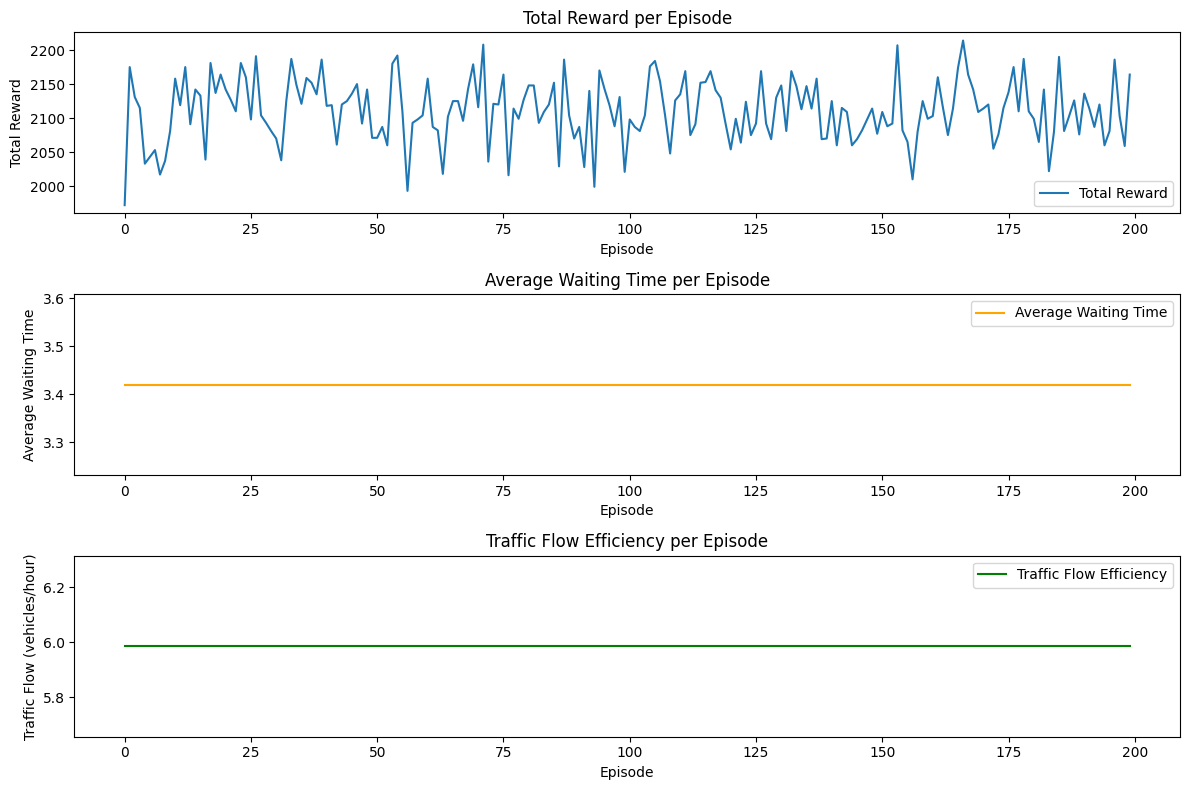

In [5]:
import traci
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

# DQN parameters
ALPHA = 0.1
GAMMA = 0.9
EPSILON = 0.1
MAX_EPISODES = 200
STATE_SIZE = 2  # High density, Ramp queue length
ACTION_SIZE = 2  # Actions: manage ramp flow, do nothing
BUFFER_SIZE = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Experience replay buffer
experience_replay = deque(maxlen=BUFFER_SIZE)

# Define the Q-network (Neural Network)
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize the Q-network and optimizer
q_network = QNetwork(STATE_SIZE, ACTION_SIZE)
optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

def get_state():
    """
    State Representation:
    State = (Highway lane density, Ramp queue length)
    """
    highway_density = min(len(traci.edge.getLastStepVehicleIDs("highway")), 4)
    ramp_queue = min(len(traci.edge.getLastStepVehicleIDs("ramp")), 4)
    return np.array([highway_density, ramp_queue], dtype=np.float32)

def get_action(state):
    """
    Epsilon-greedy action selection using the Q-network.
    """
    if random.uniform(0, 1) < EPSILON:
        return random.choice(range(ACTION_SIZE))  # Explore: random action
    else:
        state_tensor = torch.from_numpy(state).unsqueeze(0)  # Add batch dimension
        q_values = q_network(state_tensor)  # Get Q-values from the network
        return torch.argmax(q_values).item()  # Exploit: best action

def take_action(action):
    """
    Actions:
    0: Allow more vehicles to merge from the ramp.
    1: Do nothing.
    """
    if action == 0:
        # Simulate allowing vehicles from the ramp to merge more freely
        pass  # Implement any specific logic if needed
    elif action == 1:
        # Maintain the current traffic flow
        pass

def get_reward(state, action):
    ramp_queue = len(traci.edge.getLastStepVehicleIDs("ramp"))
    highway_density = len(traci.edge.getLastStepVehicleIDs("highway"))
    if action == 0 and ramp_queue > 0:
        return 10  # Reward for reducing ramp queue
    elif action == 1 and highway_density < 3:
        return 5  # Reward for smooth highway flow
    else:
        return -1  # Penalize otherwise

# Store metrics for visualization
total_rewards = []
average_waiting_times = []
traffic_flows = []

def calculate_traffic_flow():
    """
    Calculate traffic flow efficiency as vehicles/hour.
    """
    highway_flow = len(traci.edge.getLastStepVehicleIDs("highway"))
    ramp_flow = len(traci.edge.getLastStepVehicleIDs("ramp"))
    return highway_flow + ramp_flow

def calculate_average_waiting_time():
    """
    Calculate the average waiting time for vehicles at the ramp.
    """
    return traci.edge.getWaitingTime("ramp") / max(len(traci.edge.getLastStepVehicleIDs("ramp")), 1)

def train_dqn():
    global total_rewards, average_waiting_times, traffic_flows

    for episode in range(MAX_EPISODES):
        traci.start(["sumo", "-c", "/content/simulation.sumocfg"])
        state = get_state()
        done = False
        episode_reward = 0  # Cumulative reward for the episode
        waiting_times = []  # Track waiting times
        flows = []  # Track traffic flows

        while not done:
            action = get_action(state)
            take_action(action)
            traci.simulationStep()

            next_state = get_state()
            reward = get_reward(state, action)
            episode_reward += reward  # Accumulate reward

            # Track metrics
            waiting_times.append(calculate_average_waiting_time())
            flows.append(calculate_traffic_flow())

            # Store experience in replay buffer
            experience_replay.append((state, action, reward, next_state, done))

            if len(experience_replay) >= BATCH_SIZE:
                batch = random.sample(experience_replay, BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.from_numpy(np.array(states, dtype=np.float32))
                actions = torch.tensor(actions)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.from_numpy(np.array(next_states, dtype=np.float32))
                dones = torch.tensor(dones, dtype=torch.float32)

                q_values = q_network(states)
                next_q_values = q_network(next_states).detach()
                target_q_values = rewards + GAMMA * torch.max(next_q_values, dim=1)[0] * (1 - dones)
                current_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

                loss = criterion(current_q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            if traci.simulation.getMinExpectedNumber() == 0:
                done = True

        total_rewards.append(episode_reward)
        average_waiting_times.append(np.mean(waiting_times))
        traffic_flows.append(np.mean(flows))

        print(f"Episode {episode + 1}/{MAX_EPISODES} completed. Total reward: {episode_reward}")
        traci.close()

# Train the DQN model
train_dqn()

# Visualize metrics
plt.figure(figsize=(12, 8))

# Total Reward
plt.subplot(3, 1, 1)
plt.plot(total_rewards, label="Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.legend()

# Average Waiting Time
plt.subplot(3, 1, 2)
plt.plot(average_waiting_times, label="Average Waiting Time", color="orange")
plt.xlabel("Episode")
plt.ylabel("Average Waiting Time")
plt.title("Average Waiting Time per Episode")
plt.legend()

# Traffic Flow Efficiency
plt.subplot(3, 1, 3)
plt.plot(traffic_flows, label="Traffic Flow Efficiency", color="green")
plt.xlabel("Episode")
plt.ylabel("Traffic Flow (vehicles/hour)")
plt.title("Traffic Flow Efficiency per Episode")
plt.legend()

plt.tight_layout()
plt.show()
